# Generate DEA Hotspots animations <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ls8_nbart_geomedian_annual](https://explorer.sandbox.dea.ga.gov.au/ls8_nbart_geomedian_annual)


## Description
This notebook loads DEA Hotspots data for a given time and location, and animates the data over a 2018 Geomedian underlay with fading colours that represent the age of the hotspot.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
import os
import xarray
import rasterio
import pandas as pd
import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from owslib.wms import WebMapService
from IPython.display import Image

# # Create custom cmap with dark grey at end 
#fires_cmap = get_cmap('YlOrRd').reversed()
fires_cmap = get_cmap('autumn')
fires_cmap.set_over('#8C8D8F')

#dc = datacube.Datacube(app="DEA_hotspots")


## Parameters

Set parameters used to load and visualise DEA Hotspots data

In [2]:
# Setup params
name = 'vicfires'  # name used for output files
time_period = 28  # days from current date to include in animation (e.g. a month or week of data)
y_max, x_min = -34.505141, 146.652687  # top left coordinates of bbox
y_min, x_max = -38.062278, 151.305470  # bottom right coordinates of bbox
min_confidence = 20  # minimum confidence value of hotspots to include in animation
max_features = 500000  # maximum features to load from WFS

# Visualisation params
frame_freq = '2H'  # frequency used to generate animation frames (e.g. one frame every 3 hours). Smaller numbers create longer, smoother animations but take longer to render
hotspots_markersize = 4  # size to plot hotspots on map
hotspots_alpha = 0.5  # transperancy to plot hotspots on map
fade_hours = 96  # hours used to fade hotspots from yellow to black
geomedian_res = 0.003  # resolution in degrees to load geomedian underlay (smaller = slower rendering)

## Load and clean hotspots data

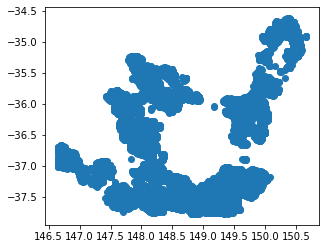

In [3]:
# Load WFS query data
to_date = dt.datetime.today().strftime('%Y-%m-%d')  
from_date = (dt.datetime.today() - dt.timedelta(days=time_period)).strftime('%Y-%m-%d')
url = f"https://hotspots.dea.ga.gov.au/geoserver/public/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=public:hotspots&outputFormat=application/json&CQL_FILTER=((sensor=%27AVHRR%27%20AND%20(product=%27SRSS%27))%20OR%20(sensor=%27MODIS%27%20AND%20(product=%27MOD14%27))%20OR%20(sensor=%27VIIRS%27%20AND%20(product=%27AFMOD%27%20OR%20product=%27EDR%27)))%20AND%20datetime%20%3E%20%27{from_date}%27%20AND%20datetime%20%3C%20%27{to_date}%27%20AND%20INTERSECTS(location,%20POLYGON(({y_min}%20{x_min},%20{y_min}%20{x_max},%20{y_max}%20{x_max},%20{y_max}%20{x_min},%20{y_min}%20{x_min})))&maxFeatures={max_features}&startIndex=0&sortBy=sensor%20A"
hotspots_gdf = gpd.read_file(url)

# Filter by confidence
hotspots_gdf = hotspots_gdf.loc[hotspots_gdf.confidence >= min_confidence]

# Fix datetime
hotspots_gdf['datetime'] = pd.to_datetime(hotspots_gdf['start_dt'])

# Extract required columns
hotspots_gdf = hotspots_gdf.loc[:, [
    'datetime', 'latitude', 'longitude', 'confidence', 'geometry'
]]
hotspots_gdf.sort_values('datetime', ascending=True, inplace=True)
hotspots_gdf.plot()

## Load 2018 geomedian underlay

In [3]:
url = "https://gsky.nci.org.au/ows/dea"
wms = WebMapService(url, version='1.3.0')
available_layers = list(wms.contents)

layer = "landsat8_geomedian"
crs = sorted(wms[layer].crsOptions)
bbox = wms[layer].boundingBox
time = wms[layer].timepositions
styles = wms[layer].styles

In [15]:
output = wms.getmap(layers=[layer],
                        Styles='tc',
                        srs=crs[2],
                        bbox=(x_min, y_min, x_max, y_max),
                        size=(512, 512),
                        format='image/geotiff',
                        time=time[5]
                        )

In [16]:
#Image(output.read())

In [25]:
geotifffile = 'nswfires.tif'
from PIL import Image
with open(geotifffile, 'wb') as out:
    out.write(output.read())
#im = Image.open(geotifffile)
#plt.figure(figsize=(10, 10))
#plt.imshow(im)

In [94]:
x_min

146.652687

In [95]:
infile='vichotspots.tif'
outfile='vichotspots_georef.tif'
from osgeo import gdal
ds = gdal.Open(infile)
ds = gdal.Translate(outfile, ds, projWin = [ x_min, y_min, x_max, y_max  ], projWinSRS = 'EPSG:4326')

In [78]:
!gdal_translate -a_srs 'EPSG:4326' -a_ullr $x_min $y_max $x_max $y_min -of 'GTIFF' 'qldhotspots.tif' 'qldhotspots_geo.tif'

Input file size is 512, 512
0...10...20...30...40...50...60...70...80...90...100 - done.


In [84]:
infile = 'vichotspots.tif'
outifle = 'vichotspots_georef.tif'
os.system('gdal_translate -a_srs epsg -a_ullr $x_min $y_max $x_max $y_min -of GTIFF $infile $outfile')

256

In [85]:
from affine import Affine

In [86]:
import xarray as xr
import numpy as np

In [98]:
ds = xr.open_rasterio('vichotspots.tif')

<xarray.DataArray (band: 4, y: 512, x: 512)>
[1048576 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1 2 3 4
  * y        (y) float64 0.5 1.5 2.5 3.5 4.5 ... 507.5 508.5 509.5 510.5 511.5
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 507.5 508.5 509.5 510.5 511.5
Attributes:
    transform:   (1.0, 0.0, 0.0, 0.0, 1.0, 0.0)
    res:         (1.0, -1.0)
    is_tiled:    0
    nodatavals:  (nan, nan, nan, nan)
    scales:      (1.0, 1.0, 1.0, 1.0)
    offsets:     (0.0, 0.0, 0.0, 0.0)

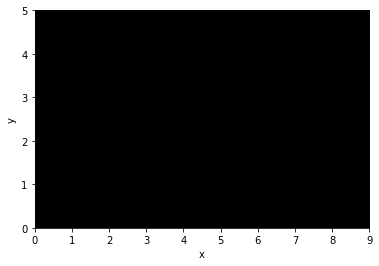

In [89]:
ds[[0,1,2]].plot.imshow()

## Generate animation frames

2019-12-26 03:26:45


/home/simonaoliver/anaconda3/envs/animation/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


2019-12-26 05:26:45
2019-12-26 07:26:45
2019-12-26 09:26:45
2019-12-26 11:26:45
2019-12-26 13:26:45
2019-12-26 15:26:45
2019-12-26 17:26:45
2019-12-26 19:26:45
2019-12-26 21:26:45
2019-12-26 23:26:45
2019-12-27 01:26:45
2019-12-27 03:26:45
2019-12-27 05:26:45
2019-12-27 07:26:45
2019-12-27 09:26:45
2019-12-27 11:26:45
2019-12-27 13:26:45
2019-12-27 15:26:45
2019-12-27 17:26:45
2019-12-27 19:26:45
2019-12-27 21:26:45
2019-12-27 23:26:45
2019-12-28 01:26:45
2019-12-28 03:26:45
2019-12-28 05:26:45
2019-12-28 07:26:45
2019-12-28 09:26:45
2019-12-28 11:26:45
2019-12-28 13:26:45
2019-12-28 15:26:45
2019-12-28 17:26:45
2019-12-28 19:26:45
2019-12-28 21:26:45
2019-12-28 23:26:45
2019-12-29 01:26:45
2019-12-29 03:26:45
2019-12-29 05:26:45
2019-12-29 07:26:45
2019-12-29 09:26:45
2019-12-29 11:26:45
2019-12-29 13:26:45
2019-12-29 15:26:45
2019-12-29 17:26:45
2019-12-29 19:26:45
2019-12-29 21:26:45
2019-12-29 23:26:45
2019-12-30 01:26:45
2019-12-30 03:26:45
2019-12-30 05:26:45
2019-12-30 07:26:45


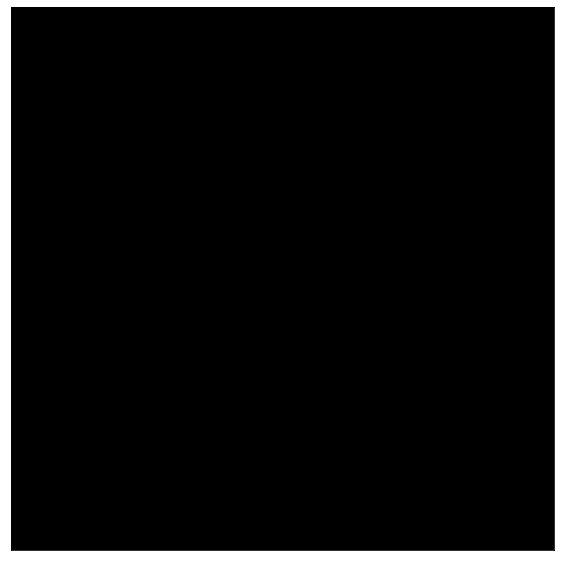

In [31]:
# If output folder doesn't exist, create it
output_dir = f'frames_{name}'
os.makedirs(output_dir, exist_ok=True)

# Get date/times to iterate through (1 per frame)
comp_dates = pd.date_range(hotspots_gdf.datetime.min(), 
                           hotspots_gdf.datetime.max(), 
                           freq=frame_freq)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i, comp_date in enumerate(comp_dates):
    
    print(comp_date)

    # Extract only hotspots occuring prior to frame date/time
    hotspots_prev = hotspots_gdf.loc[
        hotspots_gdf['datetime'] < comp_date].copy()
    
    # Calculate hours between frame date and hotspot and sort
    hotspots_prev['hours_before'] = ((
        (comp_date - hotspots_prev['datetime'])).astype('timedelta64[m]') / 60)
    hotspots_prev.sort_values('hours_before', inplace=True, ascending=False)

    # Plot Geomedian as underlay
    ds[[0,1,2]].plot.imshow(ax=ax, vmax=500)
    # Plot hotspots
    hotspots_prev.plot(ax=ax,
                       column='hours_before',
                       cmap=fires_cmap,
                       markersize=hotspots_markersize,
                       alpha=hotspots_alpha,
                       vmin=0,
                       vmax=fade_hours)
    
    # Customise plot and add title
    ax.set_facecolor('black')
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('');
    ax.text(0.03, 0.95,
            f"{comp_date.tz_localize(tz='UTC').tz_convert('Australia/Sydney'):%Y-%m-%d}",
            ha='left', 
            va='center', 
            transform=ax.transAxes,
           fontdict={'fontsize': 20, 
                     'color': 'white', 
                     'fontname':'Liberation Sans'})
    
    # Export frame to file
    fig.savefig(f'{output_dir}/hotspots_{i}.png', 
                bbox_inches='tight',
                dpi=100,
                pad_inches=0)
    plt.cla()


## Combine into MP4 animation using FFMPEG

In [21]:
!ffmpeg -y -r 12 -i $output_dir/hotspots_%d.png -c:v libx264 -vf crop=in_w-15:in_h-15,minterpolate=fps=24 -pix_fmt yuv420p $output_dir/hotspots_animation.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [25]:
!ffmpeg -y -i $output_dir/hotspots_%d.png -vf crop=in_w-15:in_h-15,minterpolate=fps=24 $output_dir/hotspots_animation.gif

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

In [8]:
print(datacube.__version__)

1.7+164.gbdf45994.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)